<a href="https://colab.research.google.com/github/preetamjumech/HR-analytics/blob/main/HR_Analytics_XGBoost_hyperparameter_tuning_using_Hyperopt_bayesian_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df=pd.read_csv('Model.csv',index_col=[0])
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,high,low,...,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3.0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5.0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3.0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [3]:
X=df.drop("left",axis=1)
y=df["left"]

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [14]:
X_train.shape

(11999, 20)

In [5]:
from xgboost import XGBClassifier

In [6]:
xgb = XGBClassifier(n_estimators=3000, max_depth=1, 
                    learning_rate=0.01, booster='gbtree')

In [7]:
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials
from hyperopt.pyll.base import scope
import hyperopt

In [8]:
hyperparameters= {
    "n_estimators":scope.int(hp.quniform("n_estimators",500,3500,1)),
    "eta":hp.uniform("eta",0.001,0.1),
    "gamma":hp.uniform("gamma",0.001,10),
    "max_depth":scope.int(hp.quniform("max_depth",1,15,1)),
    "colsample_bytree":hp.uniform("colsample_bytree",0.3,0.8),
    "lambda":hp.uniform("lambda",0.001,5),
    "alpha":hp.uniform("alpha",0.001,5)
}

In [17]:
def obj_funct(params):
  xgb=XGBClassifier(**params)
  output = cross_val_score(xgb,X_train,y_train,cv=5,scoring="roc_auc").mean()
  return output

In [18]:
def surrogate_fuc(params):
  perf=obj_funct(params)
  return {"loss":-perf,"status":STATUS_OK}

In [19]:
trials=Trials()
best_xgb = fmin(surrogate_fuc,space=hyperparameters,algo=tpe.suggest,max_evals=10,trials=trials)
print("best_xgb:")
print(best_xgb)

100%|██████████| 10/10 [17:33<00:00, 105.35s/it, best loss: -0.9936344023884954]
best_xgb:
{'alpha': 4.461394427526279, 'colsample_bytree': 0.7071754227701361, 'eta': 0.09378143924184688, 'gamma': 3.155267637611462, 'lambda': 4.759987589903952, 'max_depth': 9.0, 'n_estimators': 3470.0}


In [20]:
best_xgb_1=best_xgb.copy()
best_xgb_1["n_estimators"]=int(best_xgb_1["n_estimators"])
best_xgb_1["max_depth"]=int(best_xgb_1["max_depth"])

In [21]:
xgb_with_hyper=XGBClassifier(**best_xgb_1)
xgb_with_hyper.fit(X_train,y_train)

In [22]:
pred = xgb_with_hyper.predict(X_test)

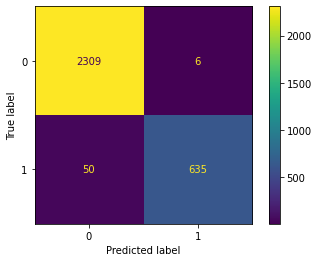

In [25]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm=confusion_matrix(y_test,pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb_with_hyper.classes_)
disp.plot()
plt.show()

In [26]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, pred)))

Model accuracy score: 0.9813
